In [9]:
# Dataset: CIFAR10

# Architecture: CNN:
    # • Conv2D (in channels=3, out channels=32, kernel size=3, padding=1) → ReLU → MaxPool2D (kernel size=2, stride=2)
    # • Conv2D (32 → 64, kernel size=3, padding=1) → ReLU → MaxPool2D (kernel size=2, stride=2)
    # • Conv2D (64 → 128, kernel size=3, padding=1) → ReLU → MaxPool2D (kernel size=2, stride=2)
    # • Flatten → Linear(128 × 4 × 4 = 2048 → 256) → ReLU → Linear(256 → 10)
# Loss: CrossEntropyLoss
# Optimizer: Adam (lr=0.001)

# Define the batch size for training and testing
batch_size = 64
learning_rate = 0.001

from tqdm import tqdm

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to convert images to tensors and normalize them
transform = transforms.Compose([
transforms.ToTensor(), # Convert PIL image to tensor
transforms.Normalize((0.4914, 0.4822, 0.4465), # Mean for each channel
                    (0.2470, 0.2435, 0.2616)) # Std for each channel
])

# Load the CIFAR-10 training dataset with transformations applied
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
# Load the CIFAR-10 test dataset with the same transformations
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
# Create a data loader for the training set
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, # Number of samples per batch
                        shuffle=True) # Shuffle the data each epoch
# Create a data loader for the test set
test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size, # Same batch size as training
                        shuffle=False) # No shuffling for test data

In [10]:
# Define the CNN model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer: 3 input channels (RGB), 32 output channels, kernel size 3, padding 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Second convolutional layer: 32 input channels, 64 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Third convolutional layer: 64 input channels, 128 output channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Fully connected layer: input size is 128*4*4 (after flattening), output size is 256
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        # Final fully connected layer: input size is 256, output size is 10 (number of classes)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        # Apply first convolutional layer, ReLU activation, and max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # Apply second convolutional layer, ReLU activation, and max pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # Apply third convolutional layer, ReLU activation, and max pooling
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        # Apply first fully connected layer and ReLU activation
        x = F.relu(self.fc1(x))
        # Apply final fully connected layer (output logits)
        x = self.fc2(x)
        return x
    

In [ ]:
# init:
model = CNN()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# check if cuda:
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")

# train over 20 epochs:
num_epochs = 20
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU if available

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss_value = loss(outputs, labels)  # Compute loss
        loss_value.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss_value.item() * images.size(0)  # Accumulate loss
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

    epoch_loss = running_loss / len(train_loader.dataset)  # Average loss for the epoch
    epoch_accuracy = correct / total * 100.0  # Accuracy for the epoch

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total * 100.0
    test_accuracies.append(test_accuracy)

    print(f"Test Accuracy: {test_accuracy:.2f}%")
# save model
torch.save(model.state_dict(), "cifar10_cnn.pth")

CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 782/782 [00:10<00:00, 74.17batch/s]


Epoch [1/20], Loss: 1.3126, Accuracy: 52.67%
Test Accuracy: 63.88%


Epoch 2/20: 100%|██████████| 782/782 [00:10<00:00, 72.86batch/s]


Epoch [2/20], Loss: 0.8580, Accuracy: 69.75%
Test Accuracy: 70.91%


Epoch 3/20: 100%|██████████| 782/782 [00:11<00:00, 68.38batch/s]


Epoch [3/20], Loss: 0.6832, Accuracy: 75.93%
Test Accuracy: 73.91%


Epoch 4/20: 100%|██████████| 782/782 [00:09<00:00, 79.20batch/s]


Epoch [4/20], Loss: 0.5648, Accuracy: 80.22%
Test Accuracy: 74.97%


Epoch 5/20: 100%|██████████| 782/782 [00:09<00:00, 79.37batch/s]


Epoch [5/20], Loss: 0.4607, Accuracy: 83.70%
Test Accuracy: 76.23%


Epoch 6/20: 100%|██████████| 782/782 [00:09<00:00, 79.91batch/s]


Epoch [6/20], Loss: 0.3707, Accuracy: 86.83%
Test Accuracy: 76.59%


Epoch 7/20: 100%|██████████| 782/782 [00:09<00:00, 79.63batch/s]


Epoch [7/20], Loss: 0.2877, Accuracy: 89.85%
Test Accuracy: 76.33%


Epoch 8/20: 100%|██████████| 782/782 [00:09<00:00, 80.57batch/s]


Epoch [8/20], Loss: 0.2225, Accuracy: 92.13%
Test Accuracy: 76.10%


Epoch 9/20: 100%|██████████| 782/782 [00:09<00:00, 78.69batch/s]


Epoch [9/20], Loss: 0.1722, Accuracy: 93.96%
Test Accuracy: 75.69%


Epoch 10/20: 100%|██████████| 782/782 [00:09<00:00, 79.39batch/s]


Epoch [10/20], Loss: 0.1427, Accuracy: 94.85%
Test Accuracy: 76.13%


Epoch 11/20: 100%|██████████| 782/782 [00:09<00:00, 81.65batch/s]


Epoch [11/20], Loss: 0.1248, Accuracy: 95.54%
Test Accuracy: 76.50%


Epoch 12/20: 100%|██████████| 782/782 [00:09<00:00, 81.22batch/s]


Epoch [12/20], Loss: 0.1051, Accuracy: 96.28%
Test Accuracy: 75.30%


Epoch 13/20: 100%|██████████| 782/782 [00:09<00:00, 78.65batch/s]


Epoch [13/20], Loss: 0.0981, Accuracy: 96.59%
Test Accuracy: 75.46%


Epoch 14/20: 100%|██████████| 782/782 [00:10<00:00, 77.92batch/s]


Epoch [14/20], Loss: 0.0836, Accuracy: 97.06%
Test Accuracy: 76.12%


Epoch 15/20: 100%|██████████| 782/782 [00:10<00:00, 73.05batch/s]


Epoch [15/20], Loss: 0.0846, Accuracy: 97.10%
Test Accuracy: 75.74%


Epoch 16/20: 100%|██████████| 782/782 [00:11<00:00, 70.90batch/s]


Epoch [16/20], Loss: 0.0796, Accuracy: 97.18%
Test Accuracy: 76.10%


Epoch 17/20: 100%|██████████| 782/782 [00:11<00:00, 67.59batch/s]


Epoch [17/20], Loss: 0.0770, Accuracy: 97.35%
Test Accuracy: 74.71%


Epoch 18/20: 100%|██████████| 782/782 [00:09<00:00, 79.01batch/s]


Epoch [18/20], Loss: 0.0766, Accuracy: 97.51%
Test Accuracy: 75.61%


Epoch 19/20: 100%|██████████| 782/782 [00:09<00:00, 78.85batch/s]


Epoch [19/20], Loss: 0.0701, Accuracy: 97.67%
Test Accuracy: 75.81%


Epoch 20/20: 100%|██████████| 782/782 [00:09<00:00, 78.92batch/s]


Epoch [20/20], Loss: 0.0731, Accuracy: 97.54%
Test Accuracy: 75.81%


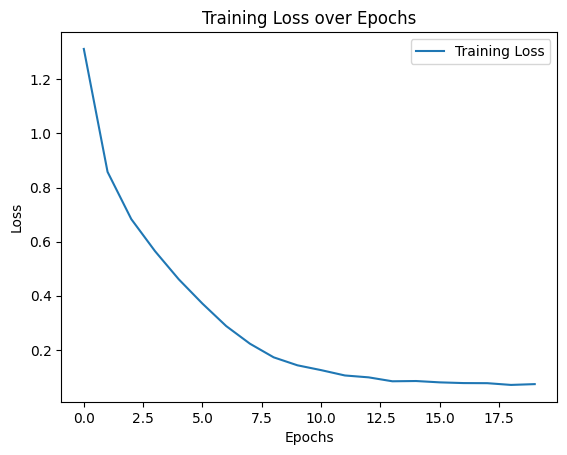

In [7]:
# plot training loss over epochs
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


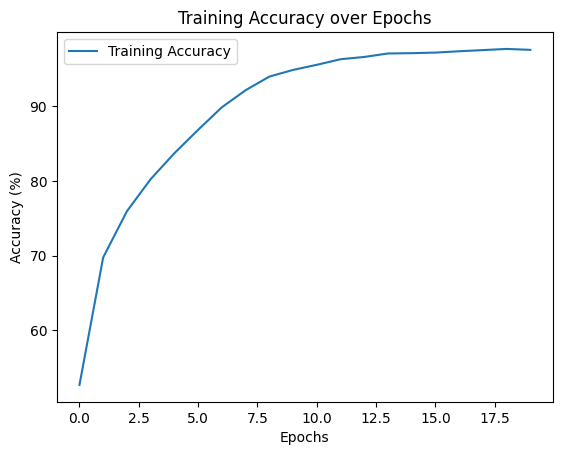

In [8]:
# training accuracy over epochs
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()


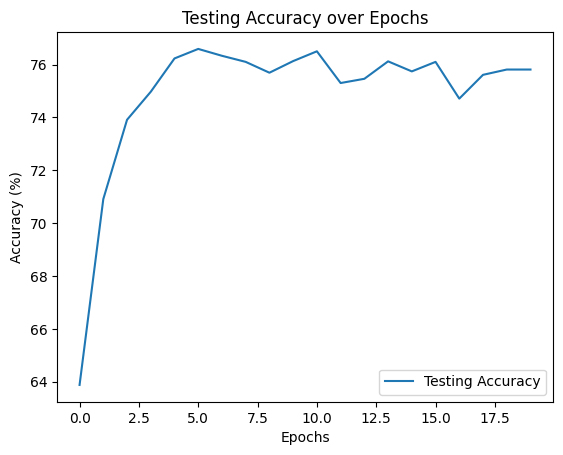

In [9]:
# testing accuracy over epochs
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy over Epochs')
plt.legend()
plt.show()

In [4]:
# 2. 
    # different hyperparameters: for each of the following, train the model and plot the training loss and accuracy over epochs:

# a) batch size = 64, learning rate = [0.01, 0.001, 0.0001]
# b) batch size = [32, 64, 128], learning rate = 0.001
# c) batch size = 64, learning rate = 0.001, optimizer = RMSProp
    # Describe observations in the difference between RMSProp and Adam optimizers

CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 782/782 [00:10<00:00, 76.56batch/s]


Epoch [1/20], Loss: 1.7475, Accuracy: 37.01%
Test Accuracy: 41.39%


Epoch 2/20: 100%|██████████| 782/782 [00:10<00:00, 78.10batch/s]


Epoch [2/20], Loss: 1.5651, Accuracy: 43.58%
Test Accuracy: 45.23%


Epoch 3/20: 100%|██████████| 782/782 [00:10<00:00, 76.67batch/s]


Epoch [3/20], Loss: 1.5203, Accuracy: 45.83%
Test Accuracy: 45.12%


Epoch 4/20: 100%|██████████| 782/782 [00:10<00:00, 74.19batch/s]


Epoch [4/20], Loss: 1.4878, Accuracy: 46.86%
Test Accuracy: 45.64%


Epoch 5/20: 100%|██████████| 782/782 [00:10<00:00, 77.48batch/s]


Epoch [5/20], Loss: 1.4631, Accuracy: 47.89%
Test Accuracy: 47.39%


Epoch 6/20: 100%|██████████| 782/782 [00:10<00:00, 77.65batch/s]


Epoch [6/20], Loss: 1.4557, Accuracy: 47.99%
Test Accuracy: 46.99%


Epoch 7/20: 100%|██████████| 782/782 [00:09<00:00, 79.25batch/s]


Epoch [7/20], Loss: 1.4391, Accuracy: 48.73%
Test Accuracy: 48.28%


Epoch 8/20: 100%|██████████| 782/782 [00:10<00:00, 77.93batch/s]


Epoch [8/20], Loss: 1.4285, Accuracy: 49.14%
Test Accuracy: 47.79%


Epoch 9/20: 100%|██████████| 782/782 [00:09<00:00, 78.89batch/s]


Epoch [9/20], Loss: 1.4303, Accuracy: 49.28%
Test Accuracy: 47.45%


Epoch 10/20: 100%|██████████| 782/782 [00:10<00:00, 76.42batch/s]


Epoch [10/20], Loss: 1.4248, Accuracy: 49.37%
Test Accuracy: 46.92%


Epoch 11/20: 100%|██████████| 782/782 [00:11<00:00, 66.32batch/s]


Epoch [11/20], Loss: 1.4072, Accuracy: 50.04%
Test Accuracy: 48.13%


Epoch 12/20: 100%|██████████| 782/782 [00:11<00:00, 68.39batch/s]


Epoch [12/20], Loss: 1.4075, Accuracy: 50.09%
Test Accuracy: 48.81%


Epoch 13/20: 100%|██████████| 782/782 [00:11<00:00, 66.77batch/s]


Epoch [13/20], Loss: 1.3988, Accuracy: 50.51%
Test Accuracy: 47.62%


Epoch 14/20: 100%|██████████| 782/782 [00:11<00:00, 69.14batch/s]


Epoch [14/20], Loss: 1.3791, Accuracy: 51.06%
Test Accuracy: 48.88%


Epoch 15/20: 100%|██████████| 782/782 [00:10<00:00, 73.86batch/s]


Epoch [15/20], Loss: 1.3814, Accuracy: 51.07%
Test Accuracy: 48.52%


Epoch 16/20: 100%|██████████| 782/782 [00:10<00:00, 72.48batch/s]


Epoch [16/20], Loss: 1.3847, Accuracy: 51.03%
Test Accuracy: 45.63%


Epoch 17/20: 100%|██████████| 782/782 [00:11<00:00, 67.27batch/s]


Epoch [17/20], Loss: 1.3721, Accuracy: 51.32%
Test Accuracy: 49.00%


Epoch 18/20: 100%|██████████| 782/782 [00:11<00:00, 67.17batch/s]


Epoch [18/20], Loss: 1.3681, Accuracy: 51.50%
Test Accuracy: 49.21%


Epoch 19/20: 100%|██████████| 782/782 [00:11<00:00, 67.34batch/s]


Epoch [19/20], Loss: 1.3723, Accuracy: 51.58%
Test Accuracy: 46.58%


Epoch 20/20: 100%|██████████| 782/782 [00:11<00:00, 70.70batch/s]


Epoch [20/20], Loss: 1.3604, Accuracy: 52.15%
Test Accuracy: 46.47%


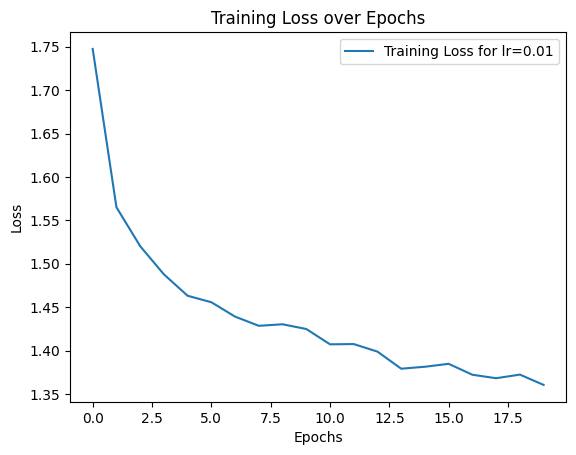

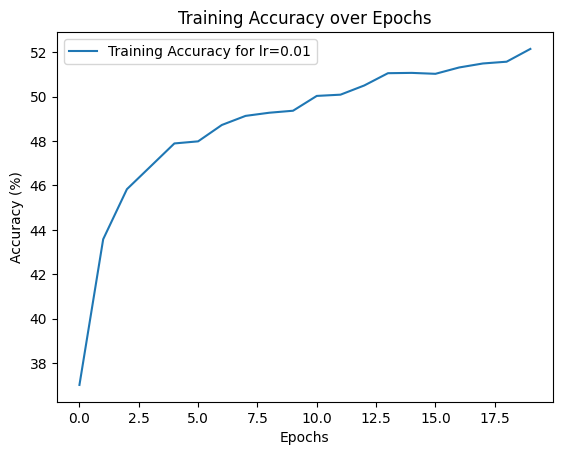

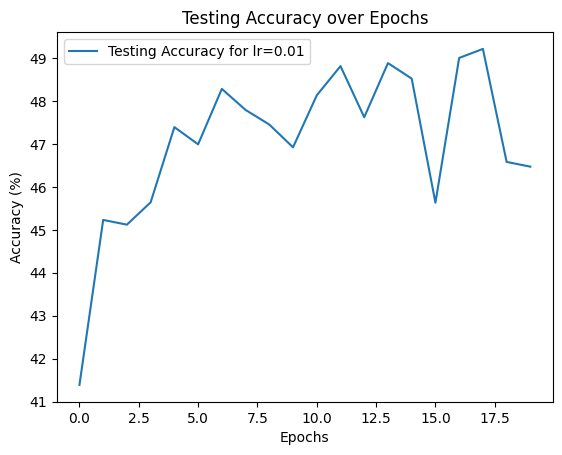

CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 782/782 [00:10<00:00, 75.22batch/s]


Epoch [1/20], Loss: 1.3103, Accuracy: 52.54%
Test Accuracy: 65.24%


Epoch 2/20: 100%|██████████| 782/782 [00:10<00:00, 72.29batch/s]


Epoch [2/20], Loss: 0.8764, Accuracy: 69.42%
Test Accuracy: 71.66%


Epoch 3/20: 100%|██████████| 782/782 [00:11<00:00, 66.62batch/s]


Epoch [3/20], Loss: 0.6946, Accuracy: 75.56%
Test Accuracy: 72.91%


Epoch 4/20: 100%|██████████| 782/782 [00:11<00:00, 69.38batch/s]


Epoch [4/20], Loss: 0.5691, Accuracy: 80.07%
Test Accuracy: 74.12%


Epoch 5/20: 100%|██████████| 782/782 [00:10<00:00, 71.67batch/s]


Epoch [5/20], Loss: 0.4634, Accuracy: 83.69%
Test Accuracy: 76.38%


Epoch 6/20: 100%|██████████| 782/782 [00:11<00:00, 68.20batch/s]


Epoch [6/20], Loss: 0.3660, Accuracy: 86.97%
Test Accuracy: 75.26%


Epoch 7/20: 100%|██████████| 782/782 [00:11<00:00, 68.63batch/s]


Epoch [7/20], Loss: 0.2788, Accuracy: 90.09%
Test Accuracy: 75.55%


Epoch 8/20: 100%|██████████| 782/782 [00:10<00:00, 76.45batch/s]


Epoch [8/20], Loss: 0.2092, Accuracy: 92.59%
Test Accuracy: 75.77%


Epoch 9/20: 100%|██████████| 782/782 [00:11<00:00, 70.48batch/s]


Epoch [9/20], Loss: 0.1609, Accuracy: 94.20%
Test Accuracy: 74.93%


Epoch 10/20: 100%|██████████| 782/782 [00:10<00:00, 74.94batch/s]


Epoch [10/20], Loss: 0.1320, Accuracy: 95.29%
Test Accuracy: 75.34%


Epoch 11/20: 100%|██████████| 782/782 [00:09<00:00, 78.97batch/s]


Epoch [11/20], Loss: 0.1170, Accuracy: 95.91%
Test Accuracy: 74.32%


Epoch 12/20: 100%|██████████| 782/782 [00:10<00:00, 75.04batch/s]


Epoch [12/20], Loss: 0.1133, Accuracy: 96.01%
Test Accuracy: 74.92%


Epoch 13/20: 100%|██████████| 782/782 [00:10<00:00, 74.26batch/s]


Epoch [13/20], Loss: 0.0911, Accuracy: 96.83%
Test Accuracy: 74.45%


Epoch 14/20: 100%|██████████| 782/782 [00:11<00:00, 70.35batch/s]


Epoch [14/20], Loss: 0.0903, Accuracy: 96.90%
Test Accuracy: 75.28%


Epoch 15/20: 100%|██████████| 782/782 [00:10<00:00, 71.66batch/s]


Epoch [15/20], Loss: 0.0756, Accuracy: 97.37%
Test Accuracy: 74.47%


Epoch 16/20: 100%|██████████| 782/782 [00:10<00:00, 71.70batch/s]


Epoch [16/20], Loss: 0.0820, Accuracy: 97.21%
Test Accuracy: 74.14%


Epoch 17/20: 100%|██████████| 782/782 [00:10<00:00, 74.66batch/s]


Epoch [17/20], Loss: 0.0853, Accuracy: 97.07%
Test Accuracy: 74.62%


Epoch 18/20: 100%|██████████| 782/782 [00:10<00:00, 74.39batch/s]


Epoch [18/20], Loss: 0.0714, Accuracy: 97.56%
Test Accuracy: 74.12%


Epoch 19/20: 100%|██████████| 782/782 [00:10<00:00, 75.96batch/s]


Epoch [19/20], Loss: 0.0690, Accuracy: 97.64%
Test Accuracy: 74.52%


Epoch 20/20: 100%|██████████| 782/782 [00:10<00:00, 72.57batch/s]


Epoch [20/20], Loss: 0.0654, Accuracy: 97.78%
Test Accuracy: 75.03%


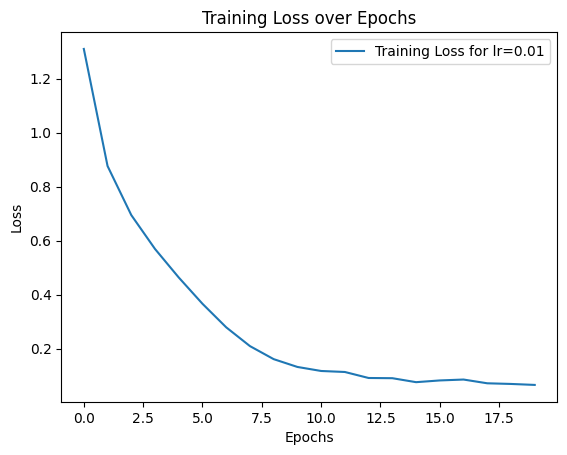

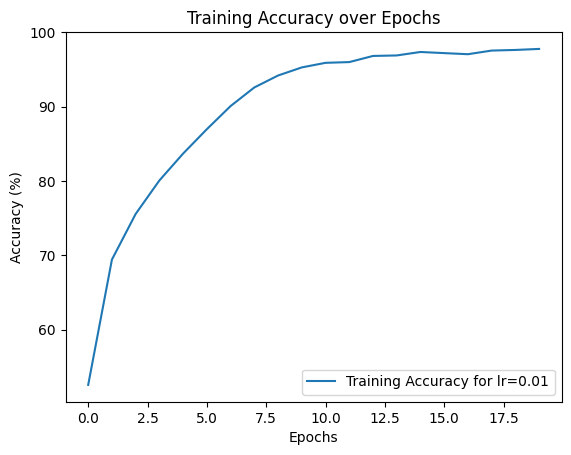

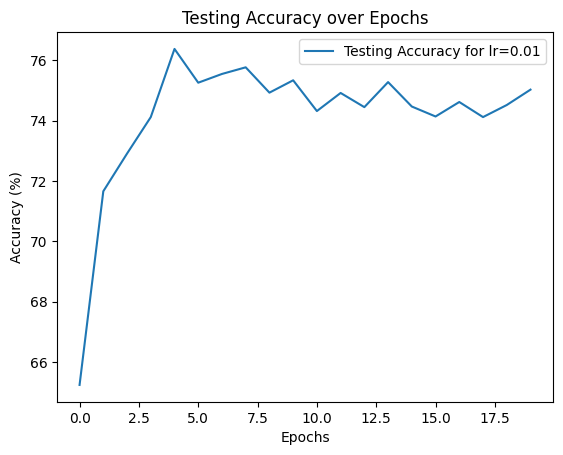

CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 782/782 [00:10<00:00, 73.03batch/s]


Epoch [1/20], Loss: 1.6795, Accuracy: 39.61%
Test Accuracy: 48.25%


Epoch 2/20: 100%|██████████| 782/782 [00:10<00:00, 73.54batch/s]


Epoch [2/20], Loss: 1.3746, Accuracy: 50.71%
Test Accuracy: 53.87%


Epoch 3/20: 100%|██████████| 782/782 [00:10<00:00, 74.24batch/s]


Epoch [3/20], Loss: 1.2517, Accuracy: 55.68%
Test Accuracy: 56.38%


Epoch 4/20: 100%|██████████| 782/782 [00:10<00:00, 78.18batch/s]


Epoch [4/20], Loss: 1.1560, Accuracy: 59.03%
Test Accuracy: 59.15%


Epoch 5/20: 100%|██████████| 782/782 [00:09<00:00, 78.22batch/s]


Epoch [5/20], Loss: 1.0743, Accuracy: 62.11%
Test Accuracy: 63.18%


Epoch 6/20: 100%|██████████| 782/782 [00:09<00:00, 78.52batch/s]


Epoch [6/20], Loss: 1.0107, Accuracy: 64.67%
Test Accuracy: 64.01%


Epoch 7/20: 100%|██████████| 782/782 [00:10<00:00, 76.20batch/s]


Epoch [7/20], Loss: 0.9548, Accuracy: 66.70%
Test Accuracy: 65.33%


Epoch 8/20: 100%|██████████| 782/782 [00:10<00:00, 76.12batch/s]


Epoch [8/20], Loss: 0.9081, Accuracy: 68.42%
Test Accuracy: 66.43%


Epoch 9/20: 100%|██████████| 782/782 [00:10<00:00, 78.08batch/s]


Epoch [9/20], Loss: 0.8682, Accuracy: 69.80%
Test Accuracy: 68.04%


Epoch 10/20: 100%|██████████| 782/782 [00:10<00:00, 76.11batch/s]


Epoch [10/20], Loss: 0.8301, Accuracy: 71.25%
Test Accuracy: 67.84%


Epoch 11/20: 100%|██████████| 782/782 [00:10<00:00, 71.99batch/s]


Epoch [11/20], Loss: 0.7981, Accuracy: 72.58%
Test Accuracy: 69.51%


Epoch 12/20: 100%|██████████| 782/782 [00:11<00:00, 68.04batch/s]


Epoch [12/20], Loss: 0.7644, Accuracy: 73.58%
Test Accuracy: 69.97%


Epoch 13/20: 100%|██████████| 782/782 [00:10<00:00, 72.86batch/s]


Epoch [13/20], Loss: 0.7328, Accuracy: 74.83%
Test Accuracy: 70.52%


Epoch 14/20: 100%|██████████| 782/782 [00:10<00:00, 76.94batch/s]


Epoch [14/20], Loss: 0.7053, Accuracy: 75.73%
Test Accuracy: 71.14%


Epoch 15/20: 100%|██████████| 782/782 [00:10<00:00, 71.18batch/s]


Epoch [15/20], Loss: 0.6756, Accuracy: 76.83%
Test Accuracy: 71.22%


Epoch 16/20: 100%|██████████| 782/782 [00:10<00:00, 72.46batch/s]


Epoch [16/20], Loss: 0.6497, Accuracy: 77.57%
Test Accuracy: 71.91%


Epoch 17/20: 100%|██████████| 782/782 [00:10<00:00, 77.04batch/s]


Epoch [17/20], Loss: 0.6252, Accuracy: 78.49%
Test Accuracy: 73.21%


Epoch 18/20: 100%|██████████| 782/782 [00:10<00:00, 73.58batch/s]


Epoch [18/20], Loss: 0.5990, Accuracy: 79.48%
Test Accuracy: 73.20%


Epoch 19/20: 100%|██████████| 782/782 [00:10<00:00, 72.29batch/s]


Epoch [19/20], Loss: 0.5748, Accuracy: 80.32%
Test Accuracy: 72.71%


Epoch 20/20: 100%|██████████| 782/782 [00:10<00:00, 76.95batch/s]


Epoch [20/20], Loss: 0.5513, Accuracy: 81.20%
Test Accuracy: 73.62%


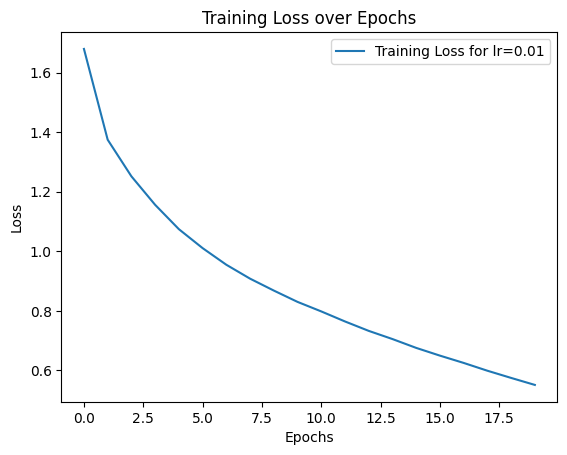

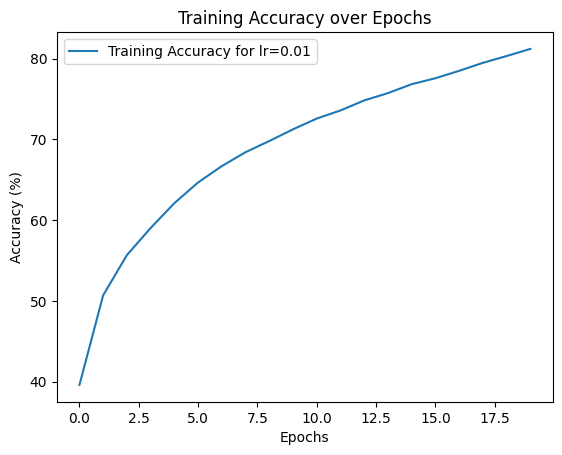

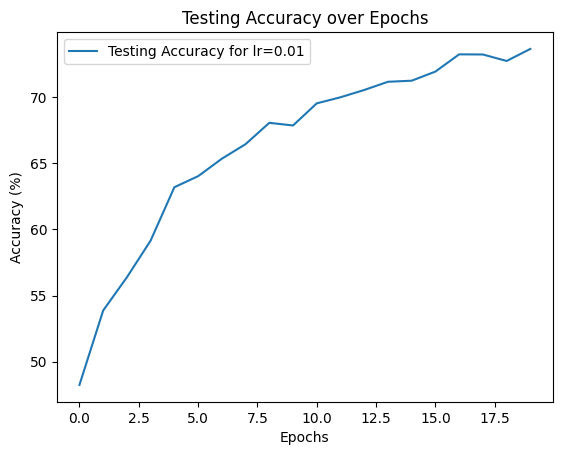

In [ ]:
import matplotlib.pyplot as plt

# a)
learning_rates = [0.01, 0.001, 0.0001]

for learning_rate in learning_rates:
    # init:
    model = CNN()
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # check if cuda:
    if torch.cuda.is_available():
        print("CUDA is available. Training on GPU.")
    else:
        print("CUDA is not available. Training on CPU.")

    # train over 20 epochs:
    num_epochs = 20
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Iterate over the training data
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU if available

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss_value = loss(outputs, labels)  # Compute loss
            loss_value.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss_value.item() * images.size(0)  # Accumulate loss
            _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
            total += labels.size(0)  # Total number of samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

        epoch_loss = running_loss / len(train_loader.dataset)  # Average loss for the epoch
        epoch_accuracy = correct / total * 100.0  # Accuracy for the epoch

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation for testing
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = correct / total * 100.0
        test_accuracies.append(test_accuracy)

        print(f"Test Accuracy: {test_accuracy:.2f}%")
    # plot for each LR: 
    plt.plot(train_losses, label=f'Training Loss for lr={learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label=f'Training Accuracy for lr={learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy over Epochs')
    plt.legend()
    plt.show()

    plt.plot(test_accuracies, label=f'Testing Accuracy for lr={learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Testing Accuracy over Epochs')
    plt.legend()
    plt.show()

Training with batch size: 32
CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 1563/1563 [00:12<00:00, 121.61batch/s]


Epoch [1/20], Loss: 1.3014, Accuracy: 53.05%
Test Accuracy: 65.27%


Epoch 2/20: 100%|██████████| 1563/1563 [00:12<00:00, 121.64batch/s]


Epoch [2/20], Loss: 0.8690, Accuracy: 69.42%
Test Accuracy: 71.18%


Epoch 3/20: 100%|██████████| 1563/1563 [00:12<00:00, 121.89batch/s]


Epoch [3/20], Loss: 0.6887, Accuracy: 75.67%
Test Accuracy: 72.78%


Epoch 4/20: 100%|██████████| 1563/1563 [00:12<00:00, 127.01batch/s]


Epoch [4/20], Loss: 0.5659, Accuracy: 79.91%
Test Accuracy: 74.08%


Epoch 5/20: 100%|██████████| 1563/1563 [00:11<00:00, 134.10batch/s]


Epoch [5/20], Loss: 0.4559, Accuracy: 83.87%
Test Accuracy: 75.82%


Epoch 6/20: 100%|██████████| 1563/1563 [00:11<00:00, 131.20batch/s]


Epoch [6/20], Loss: 0.3672, Accuracy: 86.96%
Test Accuracy: 74.77%


Epoch 7/20: 100%|██████████| 1563/1563 [00:12<00:00, 128.57batch/s]


Epoch [7/20], Loss: 0.2887, Accuracy: 89.65%
Test Accuracy: 75.13%


Epoch 8/20: 100%|██████████| 1563/1563 [00:12<00:00, 126.86batch/s]


Epoch [8/20], Loss: 0.2360, Accuracy: 91.65%
Test Accuracy: 74.46%


Epoch 9/20: 100%|██████████| 1563/1563 [00:12<00:00, 126.19batch/s]


Epoch [9/20], Loss: 0.1927, Accuracy: 93.21%
Test Accuracy: 74.04%


Epoch 10/20: 100%|██████████| 1563/1563 [00:12<00:00, 129.05batch/s]


Epoch [10/20], Loss: 0.1682, Accuracy: 94.08%
Test Accuracy: 74.32%


Epoch 11/20: 100%|██████████| 1563/1563 [00:12<00:00, 124.51batch/s]


Epoch [11/20], Loss: 0.1431, Accuracy: 94.98%
Test Accuracy: 74.35%


Epoch 12/20: 100%|██████████| 1563/1563 [00:12<00:00, 123.36batch/s]


Epoch [12/20], Loss: 0.1339, Accuracy: 95.31%
Test Accuracy: 73.77%


Epoch 13/20: 100%|██████████| 1563/1563 [00:11<00:00, 132.33batch/s]


Epoch [13/20], Loss: 0.1232, Accuracy: 95.73%
Test Accuracy: 74.47%


Epoch 14/20: 100%|██████████| 1563/1563 [00:12<00:00, 123.72batch/s]


Epoch [14/20], Loss: 0.1213, Accuracy: 95.80%
Test Accuracy: 74.15%


Epoch 15/20: 100%|██████████| 1563/1563 [00:12<00:00, 122.87batch/s]


Epoch [15/20], Loss: 0.1139, Accuracy: 96.26%
Test Accuracy: 74.03%


Epoch 16/20: 100%|██████████| 1563/1563 [00:13<00:00, 119.18batch/s]


Epoch [16/20], Loss: 0.1075, Accuracy: 96.37%
Test Accuracy: 74.44%


Epoch 17/20: 100%|██████████| 1563/1563 [00:12<00:00, 122.34batch/s]


Epoch [17/20], Loss: 0.1007, Accuracy: 96.69%
Test Accuracy: 73.91%


Epoch 18/20: 100%|██████████| 1563/1563 [00:12<00:00, 126.31batch/s]


Epoch [18/20], Loss: 0.1051, Accuracy: 96.54%
Test Accuracy: 74.60%


Epoch 19/20: 100%|██████████| 1563/1563 [00:12<00:00, 124.24batch/s]


Epoch [19/20], Loss: 0.0988, Accuracy: 96.73%
Test Accuracy: 73.48%


Epoch 20/20: 100%|██████████| 1563/1563 [00:12<00:00, 125.25batch/s]


Epoch [20/20], Loss: 0.1003, Accuracy: 96.83%
Test Accuracy: 73.00%


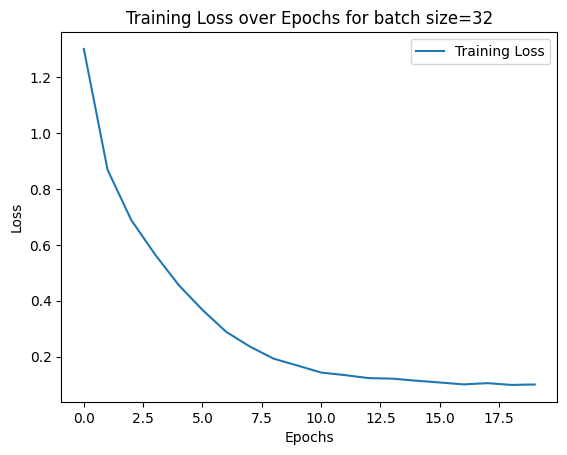

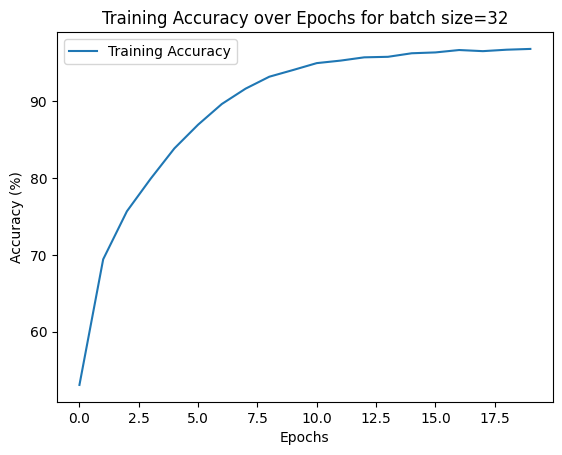

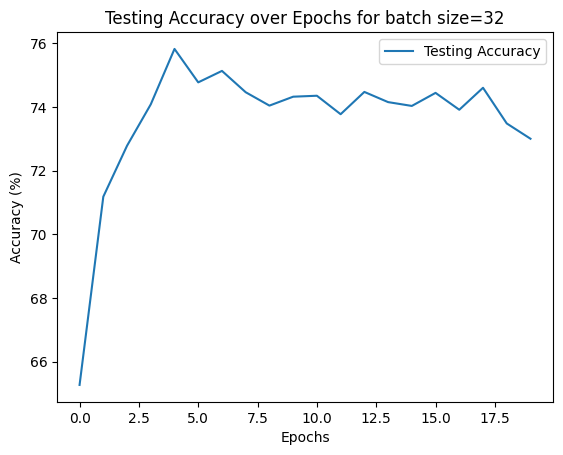

Training with batch size: 64
CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 782/782 [00:10<00:00, 75.08batch/s]


Epoch [1/20], Loss: 1.3339, Accuracy: 51.99%
Test Accuracy: 62.76%


Epoch 2/20: 100%|██████████| 782/782 [00:11<00:00, 69.99batch/s]


Epoch [2/20], Loss: 0.8999, Accuracy: 68.44%
Test Accuracy: 69.25%


Epoch 3/20: 100%|██████████| 782/782 [00:10<00:00, 75.37batch/s]


Epoch [3/20], Loss: 0.7199, Accuracy: 74.72%
Test Accuracy: 73.12%


Epoch 4/20: 100%|██████████| 782/782 [00:10<00:00, 73.24batch/s]


Epoch [4/20], Loss: 0.5797, Accuracy: 79.55%
Test Accuracy: 73.41%


Epoch 5/20: 100%|██████████| 782/782 [00:10<00:00, 73.07batch/s]


Epoch [5/20], Loss: 0.4707, Accuracy: 83.45%
Test Accuracy: 75.24%


Epoch 6/20: 100%|██████████| 782/782 [00:11<00:00, 71.07batch/s]


Epoch [6/20], Loss: 0.3710, Accuracy: 86.78%
Test Accuracy: 74.90%


Epoch 7/20: 100%|██████████| 782/782 [00:10<00:00, 71.78batch/s]


Epoch [7/20], Loss: 0.2888, Accuracy: 89.78%
Test Accuracy: 74.48%


Epoch 8/20: 100%|██████████| 782/782 [00:11<00:00, 70.65batch/s]


Epoch [8/20], Loss: 0.2222, Accuracy: 92.01%
Test Accuracy: 75.52%


Epoch 9/20: 100%|██████████| 782/782 [00:10<00:00, 71.91batch/s]


Epoch [9/20], Loss: 0.1748, Accuracy: 93.73%
Test Accuracy: 75.77%


Epoch 10/20: 100%|██████████| 782/782 [00:11<00:00, 70.14batch/s]


Epoch [10/20], Loss: 0.1417, Accuracy: 95.02%
Test Accuracy: 74.45%


Epoch 11/20: 100%|██████████| 782/782 [00:10<00:00, 71.56batch/s]


Epoch [11/20], Loss: 0.1216, Accuracy: 95.63%
Test Accuracy: 74.78%


Epoch 12/20: 100%|██████████| 782/782 [00:10<00:00, 71.31batch/s]


Epoch [12/20], Loss: 0.1052, Accuracy: 96.35%
Test Accuracy: 74.74%


Epoch 13/20: 100%|██████████| 782/782 [00:10<00:00, 71.99batch/s]


Epoch [13/20], Loss: 0.0974, Accuracy: 96.63%
Test Accuracy: 74.04%


Epoch 14/20: 100%|██████████| 782/782 [00:10<00:00, 75.62batch/s]


Epoch [14/20], Loss: 0.0955, Accuracy: 96.65%
Test Accuracy: 74.05%


Epoch 15/20: 100%|██████████| 782/782 [00:10<00:00, 76.57batch/s]


Epoch [15/20], Loss: 0.0793, Accuracy: 97.21%
Test Accuracy: 74.62%


Epoch 16/20: 100%|██████████| 782/782 [00:10<00:00, 74.35batch/s]


Epoch [16/20], Loss: 0.0818, Accuracy: 97.15%
Test Accuracy: 74.45%


Epoch 17/20: 100%|██████████| 782/782 [00:10<00:00, 76.73batch/s]


Epoch [17/20], Loss: 0.0743, Accuracy: 97.47%
Test Accuracy: 74.94%


Epoch 18/20: 100%|██████████| 782/782 [00:10<00:00, 73.68batch/s]


Epoch [18/20], Loss: 0.0817, Accuracy: 97.28%
Test Accuracy: 73.73%


Epoch 19/20: 100%|██████████| 782/782 [00:10<00:00, 76.85batch/s]


Epoch [19/20], Loss: 0.0777, Accuracy: 97.44%
Test Accuracy: 73.91%


Epoch 20/20: 100%|██████████| 782/782 [00:09<00:00, 79.19batch/s]


Epoch [20/20], Loss: 0.0664, Accuracy: 97.80%
Test Accuracy: 74.73%


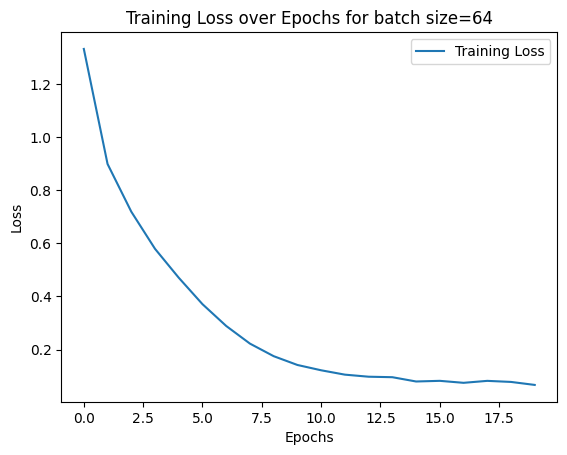

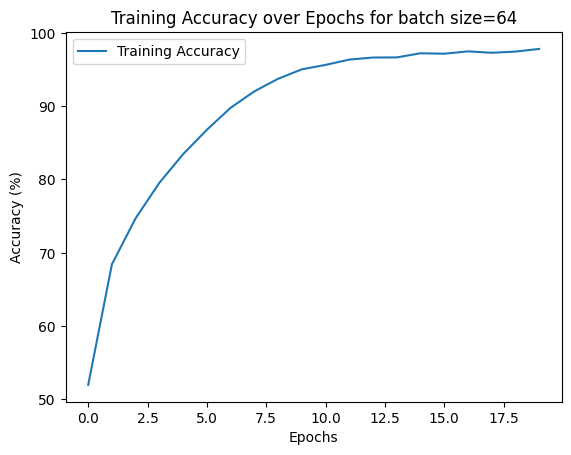

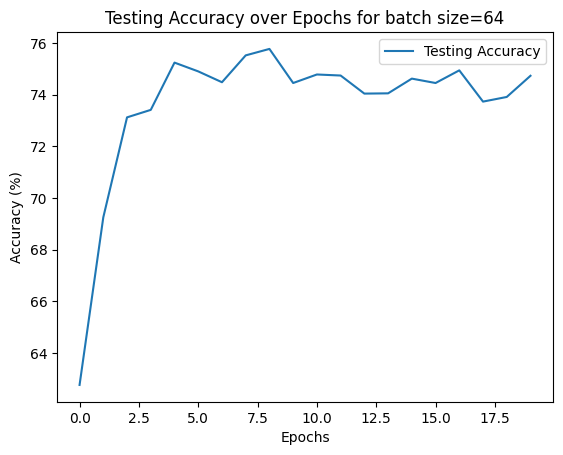

Training with batch size: 128
CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 391/391 [00:09<00:00, 40.88batch/s]


Epoch [1/20], Loss: 1.3804, Accuracy: 50.18%
Test Accuracy: 62.00%


Epoch 2/20: 100%|██████████| 391/391 [00:09<00:00, 40.80batch/s]


Epoch [2/20], Loss: 0.9565, Accuracy: 66.03%
Test Accuracy: 68.90%


Epoch 3/20: 100%|██████████| 391/391 [00:09<00:00, 41.80batch/s]


Epoch [3/20], Loss: 0.7735, Accuracy: 72.87%
Test Accuracy: 71.12%


Epoch 4/20: 100%|██████████| 391/391 [00:09<00:00, 41.54batch/s]


Epoch [4/20], Loss: 0.6471, Accuracy: 77.30%
Test Accuracy: 73.71%


Epoch 5/20: 100%|██████████| 391/391 [00:09<00:00, 41.91batch/s]


Epoch [5/20], Loss: 0.5465, Accuracy: 80.83%
Test Accuracy: 74.79%


Epoch 6/20: 100%|██████████| 391/391 [00:10<00:00, 38.88batch/s]


Epoch [6/20], Loss: 0.4523, Accuracy: 84.08%
Test Accuracy: 75.60%


Epoch 7/20: 100%|██████████| 391/391 [00:10<00:00, 38.13batch/s]


Epoch [7/20], Loss: 0.3797, Accuracy: 86.59%
Test Accuracy: 76.12%


Epoch 8/20: 100%|██████████| 391/391 [00:10<00:00, 37.20batch/s]


Epoch [8/20], Loss: 0.3004, Accuracy: 89.50%
Test Accuracy: 74.97%


Epoch 9/20: 100%|██████████| 391/391 [00:10<00:00, 37.06batch/s]


Epoch [9/20], Loss: 0.2364, Accuracy: 91.77%
Test Accuracy: 75.10%


Epoch 10/20: 100%|██████████| 391/391 [00:10<00:00, 37.11batch/s]


Epoch [10/20], Loss: 0.1824, Accuracy: 93.70%
Test Accuracy: 74.64%


Epoch 11/20: 100%|██████████| 391/391 [00:10<00:00, 37.88batch/s]


Epoch [11/20], Loss: 0.1408, Accuracy: 95.06%
Test Accuracy: 76.29%


Epoch 12/20: 100%|██████████| 391/391 [00:09<00:00, 39.27batch/s]


Epoch [12/20], Loss: 0.1095, Accuracy: 96.12%
Test Accuracy: 75.69%


Epoch 13/20: 100%|██████████| 391/391 [00:10<00:00, 38.05batch/s]


Epoch [13/20], Loss: 0.1003, Accuracy: 96.45%
Test Accuracy: 75.13%


Epoch 14/20: 100%|██████████| 391/391 [00:10<00:00, 37.84batch/s]


Epoch [14/20], Loss: 0.0843, Accuracy: 97.04%
Test Accuracy: 75.10%


Epoch 15/20: 100%|██████████| 391/391 [00:10<00:00, 37.26batch/s]


Epoch [15/20], Loss: 0.0800, Accuracy: 97.20%
Test Accuracy: 75.50%


Epoch 16/20: 100%|██████████| 391/391 [00:09<00:00, 39.14batch/s]


Epoch [16/20], Loss: 0.0787, Accuracy: 97.33%
Test Accuracy: 75.17%


Epoch 17/20: 100%|██████████| 391/391 [00:10<00:00, 38.16batch/s]


Epoch [17/20], Loss: 0.0703, Accuracy: 97.56%
Test Accuracy: 75.16%


Epoch 18/20: 100%|██████████| 391/391 [00:10<00:00, 38.77batch/s]


Epoch [18/20], Loss: 0.0639, Accuracy: 97.72%
Test Accuracy: 75.74%


Epoch 19/20: 100%|██████████| 391/391 [00:09<00:00, 40.39batch/s]


Epoch [19/20], Loss: 0.0530, Accuracy: 98.20%
Test Accuracy: 75.29%


Epoch 20/20: 100%|██████████| 391/391 [00:09<00:00, 40.10batch/s]


Epoch [20/20], Loss: 0.0534, Accuracy: 98.16%
Test Accuracy: 75.17%


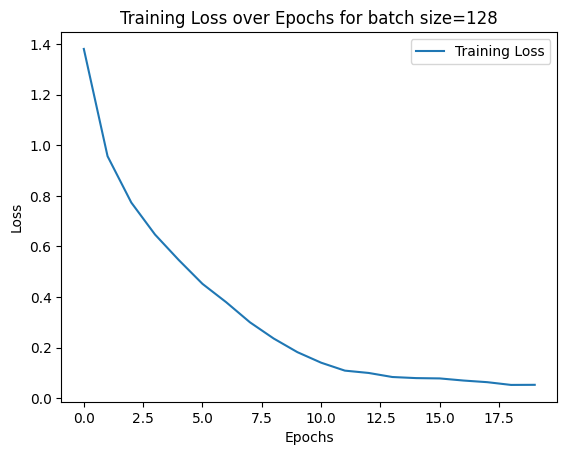

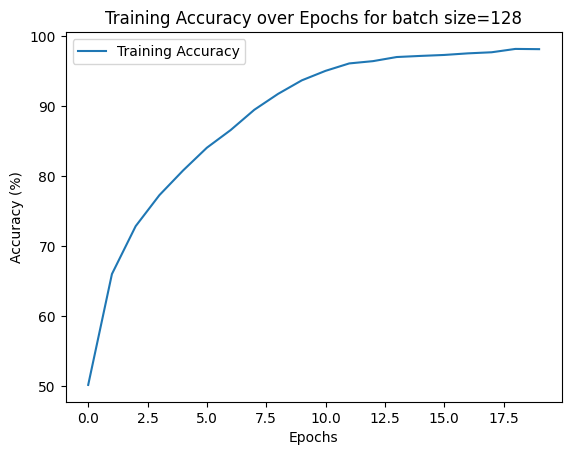

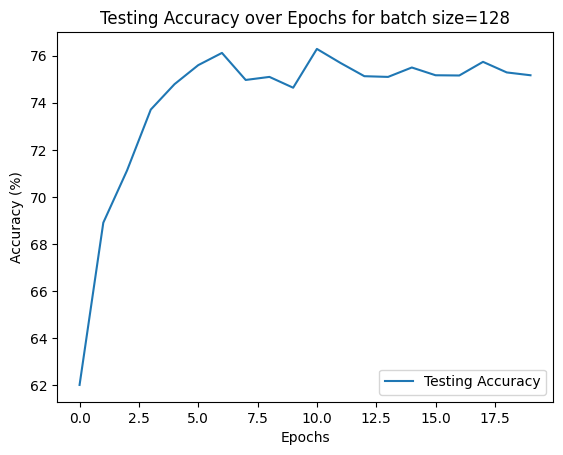

In [ ]:
# b)
import matplotlib.pyplot as plt


learning_rate = 0.001
batch_sizes = [32, 64, 128]

for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    # Create a data loader for the training set
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, # Number of samples per batch
                        shuffle=True) # Shuffle the data each epoch
    # Create a data loader for the test set
    test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size, # Same batch size as training
                        shuffle=False) # No shuffling for test data
    # init:
    model = CNN()
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # check if cuda:
    if torch.cuda.is_available():
        print("CUDA is available. Training on GPU.")
    else:
        print("CUDA is not available. Training on CPU.")

    # train over 20 epochs:
    num_epochs = 20
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Iterate over the training data
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU if available

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss_value = loss(outputs, labels)  # Compute loss
            loss_value.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss_value.item() * images.size(0)  # Accumulate loss
            _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
            total += labels.size(0)  # Total number of samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

        epoch_loss = running_loss / len(train_loader.dataset)  # Average loss for the epoch
        epoch_accuracy = correct / total * 100.0  # Accuracy for the epoch

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation for testing
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = correct / total * 100.0
        test_accuracies.append(test_accuracy)

        print(f"Test Accuracy: {test_accuracy:.2f}%")
    # plot for each batch size: 
    plt.plot(train_losses, label=f'Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss over Epochs for batch size={batch_size}')
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label=f'Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Training Accuracy over Epochs for batch size={batch_size}')
    plt.legend()
    plt.show()

    plt.plot(test_accuracies, label=f'Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Testing Accuracy over Epochs for batch size={batch_size}')
    plt.legend()
    plt.show()

CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 782/782 [00:09<00:00, 78.81batch/s]


Epoch [1/20], Loss: 1.4543, Accuracy: 48.30%
Test Accuracy: 51.94%


Epoch 2/20: 100%|██████████| 782/782 [00:10<00:00, 77.90batch/s]


Epoch [2/20], Loss: 0.9732, Accuracy: 65.72%
Test Accuracy: 61.49%


Epoch 3/20: 100%|██████████| 782/782 [00:10<00:00, 77.32batch/s]


Epoch [3/20], Loss: 0.7659, Accuracy: 73.10%
Test Accuracy: 69.78%


Epoch 4/20: 100%|██████████| 782/782 [00:09<00:00, 81.83batch/s]


Epoch [4/20], Loss: 0.6294, Accuracy: 77.98%
Test Accuracy: 71.30%


Epoch 5/20: 100%|██████████| 782/782 [00:09<00:00, 82.33batch/s]


Epoch [5/20], Loss: 0.5160, Accuracy: 81.92%
Test Accuracy: 73.17%


Epoch 6/20: 100%|██████████| 782/782 [00:09<00:00, 80.40batch/s]


Epoch [6/20], Loss: 0.4156, Accuracy: 85.48%
Test Accuracy: 72.00%


Epoch 7/20: 100%|██████████| 782/782 [00:10<00:00, 74.04batch/s]


Epoch [7/20], Loss: 0.3275, Accuracy: 88.34%
Test Accuracy: 74.81%


Epoch 8/20: 100%|██████████| 782/782 [00:10<00:00, 77.86batch/s]


Epoch [8/20], Loss: 0.2539, Accuracy: 91.02%
Test Accuracy: 74.14%


Epoch 9/20: 100%|██████████| 782/782 [00:09<00:00, 80.71batch/s]


Epoch [9/20], Loss: 0.1945, Accuracy: 93.20%
Test Accuracy: 74.29%


Epoch 10/20: 100%|██████████| 782/782 [00:09<00:00, 81.19batch/s]


Epoch [10/20], Loss: 0.1496, Accuracy: 94.67%
Test Accuracy: 74.48%


Epoch 11/20: 100%|██████████| 782/782 [00:09<00:00, 82.04batch/s]


Epoch [11/20], Loss: 0.1250, Accuracy: 95.55%
Test Accuracy: 74.51%


Epoch 12/20: 100%|██████████| 782/782 [00:09<00:00, 82.16batch/s]


Epoch [12/20], Loss: 0.1107, Accuracy: 96.14%
Test Accuracy: 74.02%


Epoch 13/20: 100%|██████████| 782/782 [00:09<00:00, 81.23batch/s]


Epoch [13/20], Loss: 0.1011, Accuracy: 96.44%
Test Accuracy: 74.22%


Epoch 14/20: 100%|██████████| 782/782 [00:09<00:00, 81.33batch/s]


Epoch [14/20], Loss: 0.0920, Accuracy: 96.75%
Test Accuracy: 67.75%


Epoch 15/20: 100%|██████████| 782/782 [00:09<00:00, 79.06batch/s]


Epoch [15/20], Loss: 0.0816, Accuracy: 97.21%
Test Accuracy: 72.96%


Epoch 16/20: 100%|██████████| 782/782 [00:10<00:00, 74.83batch/s]


Epoch [16/20], Loss: 0.0808, Accuracy: 97.28%
Test Accuracy: 75.07%


Epoch 17/20: 100%|██████████| 782/782 [00:10<00:00, 75.79batch/s]


Epoch [17/20], Loss: 0.0747, Accuracy: 97.53%
Test Accuracy: 74.27%


Epoch 18/20: 100%|██████████| 782/782 [00:09<00:00, 80.69batch/s]


Epoch [18/20], Loss: 0.0778, Accuracy: 97.46%
Test Accuracy: 73.34%


Epoch 19/20: 100%|██████████| 782/782 [00:09<00:00, 80.96batch/s]


Epoch [19/20], Loss: 0.0694, Accuracy: 97.67%
Test Accuracy: 73.92%


Epoch 20/20: 100%|██████████| 782/782 [00:10<00:00, 76.38batch/s]


Epoch [20/20], Loss: 0.0740, Accuracy: 97.62%
Test Accuracy: 73.25%


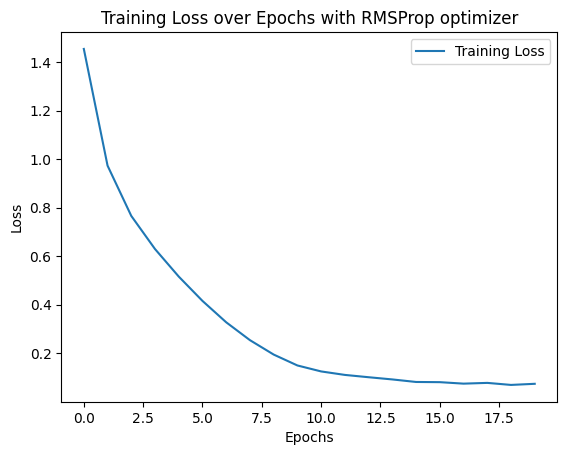

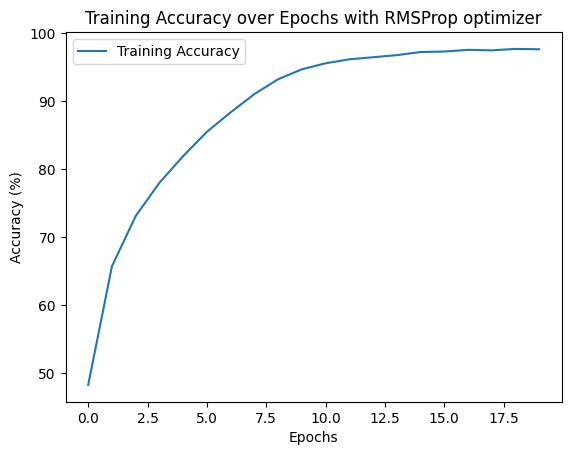

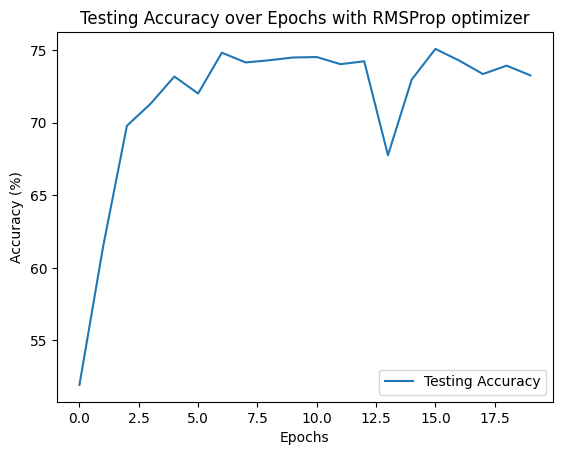

In [16]:
# c) Change optimizer to RMSProp

# reset batch size:
batch_size = 64
# Create a data loader for the training set
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, # Number of samples per batch
                        shuffle=True) # Shuffle the data each epoch
    # Create a data loader for the test set
test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size, # Same batch size as training
                        shuffle=False) # No shuffling for test data
# init:

model = CNN()
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# check if cuda:
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")

# train over 20 epochs:
num_epochs = 20
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU if available

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss_value = loss(outputs, labels)  # Compute loss
        loss_value.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss_value.item() * images.size(0)  # Accumulate loss
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

    epoch_loss = running_loss / len(train_loader.dataset)  # Average loss for the epoch
    epoch_accuracy = correct / total * 100.0  # Accuracy for the epoch

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total * 100.0
    test_accuracies.append(test_accuracy)

    print(f"Test Accuracy: {test_accuracy:.2f}%")

# plots:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training Loss over Epochs with RMSProp optimizer')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs with RMSProp optimizer')
plt.legend()
plt.show()

plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy over Epochs with RMSProp optimizer')
plt.legend()
plt.show()


In [ ]:
# 3. 
    # for batch size = 64, learning rate = 0.001, modify architecture:

# a) add a Dropout layer (p=0.5) after the first Linear layer
    # plot training loss, training accuracy, and testing accuracy over epochs
    # discuss observations
# b) add a BatchNorm2d layer before each MaxPool2d layer
    # num_features arg of BatchNorm2da should match out_channels of preceding Conv2d layer
    # plot training loss, training accuracy, and testing accuracy over epochs
    # discuss observations

In [25]:
# reset batch size and learning rate:
batch_size = 64
learning_rate = 0.001

# Create a data loader for the training set
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, # Number of samples per batch
                        shuffle=True) # Shuffle the data each epoch

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size, # Same batch size as training
                        shuffle=False) # No shuffling for test data


In [21]:
# a) add a Dropout layer (p=0.5) after the first Linear layer
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer: 3 input channels (RGB), 32 output channels, kernel size 3, padding 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Second convolutional layer: 32 input channels, 64 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Third convolutional layer: 64 input channels, 128 output channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Fully connected layer: input size is 128*4*4 (after flattening), output size is 256
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        # Dropout layer with p=0.5
        self.dropout = nn.Dropout(p=0.5)
        # Final fully connected layer: input size is 256, output size is 10 (number of classes)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        # Apply first convolutional layer, ReLU activation, and max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # Apply second convolutional layer, ReLU activation, and max pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # Apply third convolutional layer, ReLU activation, and max pooling
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        # Apply first fully connected layer and ReLU activation
        x = F.relu(self.fc1(x))
        # Apply Dropout layer
        x = self.dropout(x)
        # Apply final fully connected layer (output logits)
        x = self.fc2(x)
        return x
    

CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 782/782 [00:10<00:00, 76.22batch/s]


Epoch [1/20], Loss: 1.4600, Accuracy: 47.24%
Test Accuracy: 58.63%


Epoch 2/20: 100%|██████████| 782/782 [00:10<00:00, 72.66batch/s]


Epoch [2/20], Loss: 1.0399, Accuracy: 63.25%
Test Accuracy: 69.09%


Epoch 3/20: 100%|██████████| 782/782 [00:10<00:00, 76.27batch/s]


Epoch [3/20], Loss: 0.8746, Accuracy: 69.47%
Test Accuracy: 72.07%


Epoch 4/20: 100%|██████████| 782/782 [00:10<00:00, 77.27batch/s]


Epoch [4/20], Loss: 0.7610, Accuracy: 73.39%
Test Accuracy: 73.11%


Epoch 5/20: 100%|██████████| 782/782 [00:10<00:00, 76.59batch/s]


Epoch [5/20], Loss: 0.6770, Accuracy: 76.51%
Test Accuracy: 74.97%


Epoch 6/20: 100%|██████████| 782/782 [00:11<00:00, 70.59batch/s]


Epoch [6/20], Loss: 0.6183, Accuracy: 78.31%
Test Accuracy: 75.36%


Epoch 7/20: 100%|██████████| 782/782 [00:10<00:00, 74.68batch/s]


Epoch [7/20], Loss: 0.5575, Accuracy: 80.37%
Test Accuracy: 76.18%


Epoch 8/20: 100%|██████████| 782/782 [00:10<00:00, 74.22batch/s]


Epoch [8/20], Loss: 0.5057, Accuracy: 82.13%
Test Accuracy: 75.75%


Epoch 9/20: 100%|██████████| 782/782 [00:11<00:00, 67.29batch/s]


Epoch [9/20], Loss: 0.4675, Accuracy: 83.37%
Test Accuracy: 76.87%


Epoch 10/20: 100%|██████████| 782/782 [00:10<00:00, 74.32batch/s]


Epoch [10/20], Loss: 0.4270, Accuracy: 84.73%
Test Accuracy: 75.62%


Epoch 11/20: 100%|██████████| 782/782 [00:10<00:00, 76.58batch/s]


Epoch [11/20], Loss: 0.3908, Accuracy: 85.96%
Test Accuracy: 76.39%


Epoch 12/20: 100%|██████████| 782/782 [00:10<00:00, 77.32batch/s]


Epoch [12/20], Loss: 0.3621, Accuracy: 86.98%
Test Accuracy: 76.11%


Epoch 13/20: 100%|██████████| 782/782 [00:10<00:00, 73.99batch/s]


Epoch [13/20], Loss: 0.3419, Accuracy: 87.61%
Test Accuracy: 77.32%


Epoch 14/20: 100%|██████████| 782/782 [00:10<00:00, 74.96batch/s]


Epoch [14/20], Loss: 0.3096, Accuracy: 88.61%
Test Accuracy: 76.81%


Epoch 15/20: 100%|██████████| 782/782 [00:10<00:00, 74.70batch/s]


Epoch [15/20], Loss: 0.3002, Accuracy: 88.99%
Test Accuracy: 76.75%


Epoch 16/20: 100%|██████████| 782/782 [00:10<00:00, 74.65batch/s]


Epoch [16/20], Loss: 0.2799, Accuracy: 89.90%
Test Accuracy: 75.51%


Epoch 17/20: 100%|██████████| 782/782 [00:10<00:00, 76.96batch/s]


Epoch [17/20], Loss: 0.2692, Accuracy: 90.27%
Test Accuracy: 76.46%


Epoch 18/20: 100%|██████████| 782/782 [00:10<00:00, 75.90batch/s]


Epoch [18/20], Loss: 0.2461, Accuracy: 90.99%
Test Accuracy: 76.79%


Epoch 19/20: 100%|██████████| 782/782 [00:10<00:00, 76.91batch/s]


Epoch [19/20], Loss: 0.2452, Accuracy: 91.20%
Test Accuracy: 76.73%


Epoch 20/20: 100%|██████████| 782/782 [00:09<00:00, 80.11batch/s]


Epoch [20/20], Loss: 0.2341, Accuracy: 91.46%
Test Accuracy: 76.49%


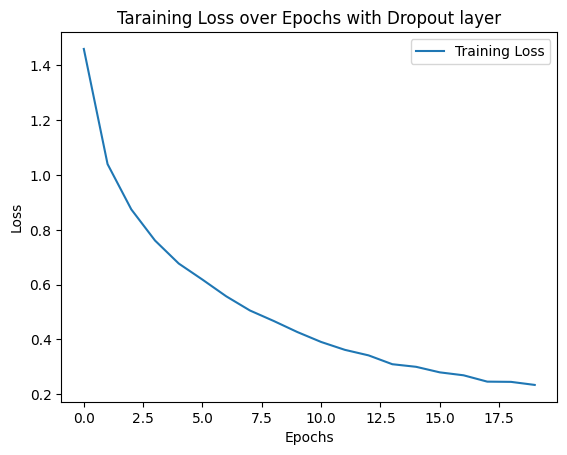

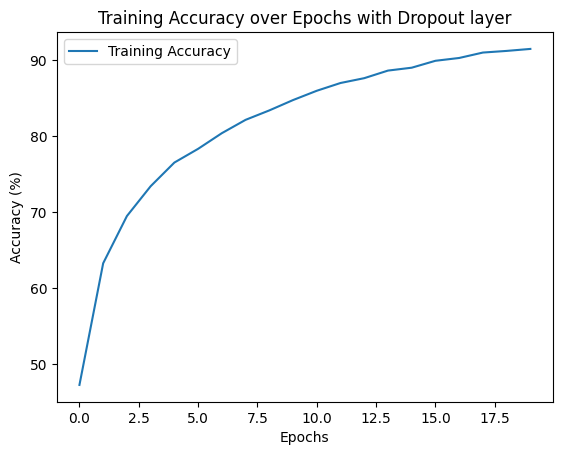

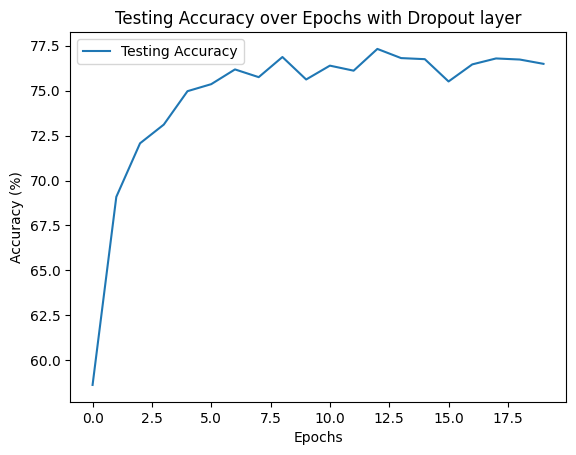

In [ ]:
# init:
model = CNN()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# check if cuda:
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")

# train over 20 epochs:
num_epochs = 20
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU if available

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss_value = loss(outputs, labels)  # Compute loss
        loss_value.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss_value.item() * images.size(0)  # Accumulate loss
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

    epoch_loss = running_loss / len(train_loader.dataset)  # Average loss for the epoch
    epoch_accuracy = correct / total * 100.0  # Accuracy for the epoch

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total * 100.0
    test_accuracies.append(test_accuracy)

    print(f"Test Accuracy: {test_accuracy:.2f}%")

# plots:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training Loss over Epochs with Dropout layer')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs with Dropout layer')
plt.legend()
plt.show()

plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy over Epochs with Dropout layer')
plt.legend()
plt.show()

In [24]:
# b) add a BatchNorm2d layer before each MaxPool2d layer
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer: 3 input channels (RGB), 32 output channels, kernel size 3, padding 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # BatchNorm2d for conv1 (32 channels)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Second convolutional layer: 32 input channels, 64 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # BatchNorm2d for conv2 (64 channels)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Third convolutional layer: 64 input channels, 128 output channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # BatchNorm2d for conv3 (128 channels)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fully connected layer: input size is 128*4*4 (after flattening), output size is 256
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        # Dropout layer with p=0.5
        self.dropout = nn.Dropout(p=0.5)
        # Final fully connected layer: input size is 256, output size is 10 (number of classes)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        # Apply first convolutional layer, ReLU activation, BatchNorm2d, and max pooling
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.max_pool2d(x, 2)
        
        # Apply second convolutional layer, ReLU activation, BatchNorm2d, and max pooling
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.max_pool2d(x, 2)
        
        # Apply third convolutional layer, ReLU activation, BatchNorm2d, and max pooling
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.max_pool2d(x, 2)
        
        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        # Apply first fully connected layer and ReLU activation
        x = F.relu(self.fc1(x))
        # Apply Dropout layer
        x = self.dropout(x)
        # Apply final fully connected layer (output logits)
        x = self.fc2(x)
        return x
    

CUDA is available. Training on GPU.


Epoch 1/20: 100%|██████████| 782/782 [00:10<00:00, 75.86batch/s]


Epoch [1/20], Loss: 1.2808, Accuracy: 54.06%
Test Accuracy: 66.38%


Epoch 2/20: 100%|██████████| 782/782 [00:10<00:00, 76.12batch/s]


Epoch [2/20], Loss: 0.9090, Accuracy: 68.31%
Test Accuracy: 71.98%


Epoch 3/20: 100%|██████████| 782/782 [00:10<00:00, 76.98batch/s]


Epoch [3/20], Loss: 0.7595, Accuracy: 73.74%
Test Accuracy: 75.50%


Epoch 4/20: 100%|██████████| 782/782 [00:10<00:00, 76.42batch/s]


Epoch [4/20], Loss: 0.6532, Accuracy: 77.15%
Test Accuracy: 77.33%


Epoch 5/20: 100%|██████████| 782/782 [00:10<00:00, 75.87batch/s]


Epoch [5/20], Loss: 0.5681, Accuracy: 80.31%
Test Accuracy: 77.30%


Epoch 6/20: 100%|██████████| 782/782 [00:10<00:00, 71.50batch/s]


Epoch [6/20], Loss: 0.4986, Accuracy: 82.68%
Test Accuracy: 77.81%


Epoch 7/20: 100%|██████████| 782/782 [00:11<00:00, 69.93batch/s]


Epoch [7/20], Loss: 0.4444, Accuracy: 84.53%
Test Accuracy: 78.32%


Epoch 8/20: 100%|██████████| 782/782 [00:10<00:00, 74.14batch/s]


Epoch [8/20], Loss: 0.4023, Accuracy: 85.79%
Test Accuracy: 78.66%


Epoch 9/20: 100%|██████████| 782/782 [00:10<00:00, 74.03batch/s]


Epoch [9/20], Loss: 0.3550, Accuracy: 87.67%
Test Accuracy: 79.24%


Epoch 10/20: 100%|██████████| 782/782 [00:10<00:00, 73.67batch/s]


Epoch [10/20], Loss: 0.3237, Accuracy: 88.57%
Test Accuracy: 78.63%


Epoch 11/20: 100%|██████████| 782/782 [00:11<00:00, 70.06batch/s]


Epoch [11/20], Loss: 0.2933, Accuracy: 89.50%
Test Accuracy: 79.39%


Epoch 12/20: 100%|██████████| 782/782 [00:10<00:00, 74.50batch/s]


Epoch [12/20], Loss: 0.2681, Accuracy: 90.60%
Test Accuracy: 78.90%


Epoch 13/20: 100%|██████████| 782/782 [00:10<00:00, 71.69batch/s]


Epoch [13/20], Loss: 0.2508, Accuracy: 91.15%
Test Accuracy: 79.23%


Epoch 14/20: 100%|██████████| 782/782 [00:10<00:00, 76.37batch/s]


Epoch [14/20], Loss: 0.2355, Accuracy: 91.76%
Test Accuracy: 78.92%


Epoch 15/20: 100%|██████████| 782/782 [00:10<00:00, 76.47batch/s]


Epoch [15/20], Loss: 0.2207, Accuracy: 92.31%
Test Accuracy: 79.70%


Epoch 16/20: 100%|██████████| 782/782 [00:10<00:00, 76.64batch/s]


Epoch [16/20], Loss: 0.2068, Accuracy: 92.79%
Test Accuracy: 79.47%


Epoch 17/20: 100%|██████████| 782/782 [00:10<00:00, 76.02batch/s]


Epoch [17/20], Loss: 0.1955, Accuracy: 93.14%
Test Accuracy: 79.59%


Epoch 18/20: 100%|██████████| 782/782 [00:10<00:00, 75.86batch/s]


Epoch [18/20], Loss: 0.1845, Accuracy: 93.55%
Test Accuracy: 79.48%


Epoch 19/20: 100%|██████████| 782/782 [00:10<00:00, 75.81batch/s]


Epoch [19/20], Loss: 0.1802, Accuracy: 93.79%
Test Accuracy: 79.29%


Epoch 20/20: 100%|██████████| 782/782 [00:10<00:00, 76.25batch/s]


Epoch [20/20], Loss: 0.1738, Accuracy: 94.01%
Test Accuracy: 79.06%


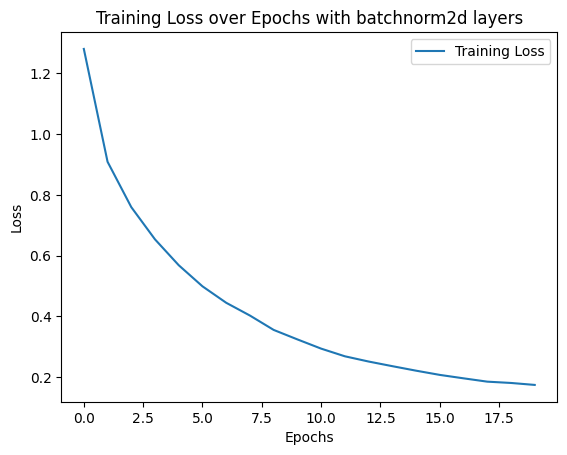

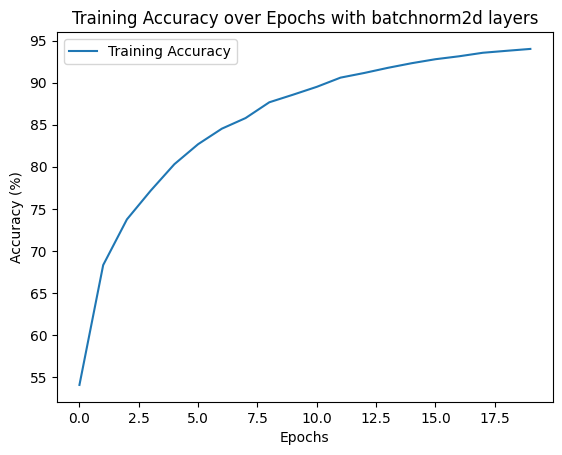

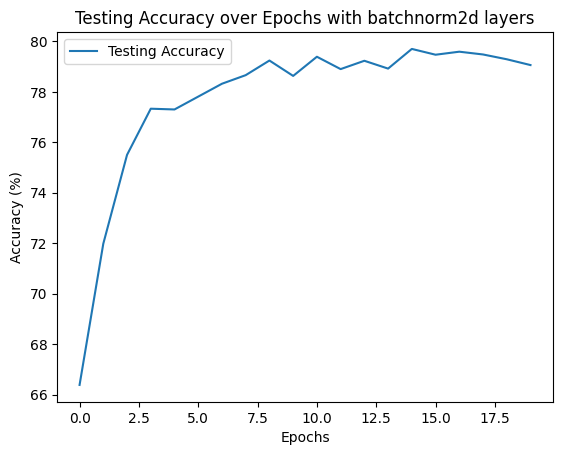

In [26]:
# init:
model = CNN()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# check if cuda:
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")

# train over 20 epochs:
num_epochs = 20
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU if available

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss_value = loss(outputs, labels)  # Compute loss
        loss_value.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss_value.item() * images.size(0)  # Accumulate loss
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

    epoch_loss = running_loss / len(train_loader.dataset)  # Average loss for the epoch
    epoch_accuracy = correct / total * 100.0  # Accuracy for the epoch

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total * 100.0
    test_accuracies.append(test_accuracy)

    print(f"Test Accuracy: {test_accuracy:.2f}%")

# plots:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training Loss over Epochs with batchnorm2d layers')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs with batchnorm2d layers')
plt.legend()
plt.show()

plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy over Epochs with batchnorm2d layers')
plt.legend()
plt.show()